## 1. Import Libraries

In [93]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchview import draw_graph

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from tqdm import tqdm
import glob
from pathlib import Path

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'pkill' is not recognized as an internal or external command,
operable program or batch file.


PyTorch version: 2.9.1+cu128
Device: cuda


A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file models already exists.
Error occurred while processing: models.


## **2. Data Loading**

In [94]:
base_path = Path.cwd().resolve()

datasets_path = base_path / "an2dl2526c2"
if not datasets_path.exists():
    fallback_path = base_path.parent / "an2dl2526c2"
    if fallback_path.exists():
        datasets_path = fallback_path
    else:
        raise FileNotFoundError(f"Dataset folder not found at {datasets_path} or {fallback_path}")

train_data_path = datasets_path / "train_data"
train_labels_path = datasets_path / "train_labels.csv"
test_data_path = datasets_path / "test_data"
output_path = datasets_path / "train_masked"

print(f"Dataset path: {datasets_path}")
print(f"Train data path: {train_data_path}")
print(f"Train labels path: {train_labels_path}")
print(f"Test data path: {test_data_path}")
print(f"Output path: {output_path}")

CSV_PATH = str(train_labels_path)
SOURCE_FOLDER = str(train_data_path)
OUTPUT_FOLDER = str(output_path)
if not Path(SOURCE_FOLDER).exists():
    candidate_datasets = [
        datasets_path,
        base_path.parent / "an2dl2526c2",
        Path(r"C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2"),
    ]
    for candidate in candidate_datasets:
        if candidate.exists():
            datasets_path = candidate
            train_data_path = datasets_path / "train_data"
            train_labels_path = datasets_path / "train_labels.csv"
            test_data_path = datasets_path / "test_data"
            output_path = datasets_path / "train_masked"

            CSV_PATH = str(train_labels_path)
            SOURCE_FOLDER = str(train_data_path)
            OUTPUT_FOLDER = str(output_path)

            print(f"Resolved dataset path: {datasets_path}")
            break
    else:
        raise FileNotFoundError(
            "Dataset folder not found in any of the candidate locations:\n"
            + "\n".join(str(p) for p in candidate_datasets)
        )


Dataset path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2
Train data path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2\train_data
Train labels path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2\train_labels.csv
Test data path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2\test_data
Output path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2\train_masked


In [95]:
def apply_mask(image_path, mask_path, output_path, target_size=(224, 224)):
    """
    Loads an image and a mask, resizes them, applies the mask, and saves the result.
    """
    # 1. Load Image
    img = cv2.imread(str(image_path))
    if img is None:
        tqdm.write(f"Error: Could not load image at {image_path}")
        return

    # 2. Load Mask (Read as grayscale)
    mask = cv2.imread(str(mask_path), 0)
    if mask is None:
        tqdm.write(f"Error: Could not load mask at {mask_path}")
        return

    # 3. Resize both to target size
    if target_size is not None:
        # Resize image using linear interpolation (better for photos)
        img = cv2.resize(img, target_size)
        # Resize mask using nearest neighbor to preserve sharp edges
        mask = cv2.resize(mask, target_size)

    # 4. Ensure mask is strictly binary (0 or 255)
    # Values > 127 become 255 (White), others become 0 (Black)
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # 5. Apply the mask
    # cv2.bitwise_and keeps the pixel where the mask is 255, and makes it 0 where mask is 0
    masked_img = cv2.bitwise_and(img, img, mask=binary_mask)

    # 6. Save result
    cv2.imwrite(str(output_path), masked_img)

In [96]:
def process_batch(input_dir, output_dir, target_size=(224, 224)):
    """
    Iterates through input_dir, finds pairs of 'img_xxxx' and 'mask_xxxx',
    resizes them to target_size, and saves the masked result to output_dir.
    """
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)
    
    # Create output directory if it doesn't exist
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Extensions to look for
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
    
    # 1. Gather all valid image files first
    print(f"Scanning for images in: {input_dir}...")
    image_files = [
        f for f in input_dir.iterdir() 
        if f.name.startswith('img_') and f.suffix.lower() in valid_extensions
    ]
    
    if not image_files:
        print("No images found starting with 'img_' in the directory.")
        return

    # 2. Iterate with tqdm
    count = 0
    
    for file_path in tqdm(image_files, desc="Processing Images", unit="img"):
        # Construct expected mask filename: img_123.jpg -> mask_123.jpg
        mask_name = file_path.name.replace('img_', 'mask_', 1)
        mask_path = input_dir / mask_name
        
        # Fallback: If mask_123.jpg doesn't exist, try mask_123.png
        if not mask_path.exists():
            mask_stem = file_path.stem.replace('img_', 'mask_', 1)
            mask_path = input_dir / (mask_stem + ".png")
        
        if mask_path.exists():
            output_path = output_dir / file_path.name
            
            if output_path.exists():
                # Skip silently
                continue

            apply_mask(file_path, mask_path, output_path, target_size=target_size)
            count += 1
        else:
            # Use tqdm.write to log errors without breaking the progress bar
            tqdm.write(f"Skipping {file_path.name}: No matching mask found (looked for {mask_name})")

    print(f"Batch processing complete. Processed {count} new images.")

In [97]:
def load_images_from_folder(folder):
    """
    Load and preprocess images from a specified folder with a progress bar.

    Args:
        folder (str): Path to the folder containing images

    Returns:
        np.ndarray: Array of preprocessed images with shape (N, H, W, C)
    """
    images = []
    
    # Get the list of files to iterate over
    file_list = os.listdir(folder)

    # Iterate through files with a tqdm progress bar
    for filename in tqdm(file_list, desc=f"Loading images from {os.path.basename(folder)}"):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)

        # Check if image was loaded successfully right away
        if img is None:
            print(f"Warning: Failed to load image at {img_path}. Skipping.")
            continue

        # Normalize image pixel values to a float range [0, 1]
        img = (img / 255.0).astype(np.float32)

        # Convert image from BGR to RGB
        img = img[..., ::-1]

        #NOTE: commented out because the images are already resized
        # Crop the image to be square
        # dim = min(img.shape[:2])
        # start_y = (img.shape[0] - dim) // 2
        # start_x = (img.shape[1] - dim) // 2
        # img = img[start_y:start_y+dim, start_x:start_x+dim, :]

        # NOTE: commented out because the images are already resized
        # Resize the image to 224x224 pixels 
        # img = cv2.resize(img, (224, 224))

        images.append(img)

    return np.array(images)

In [98]:
source_dir = Path(SOURCE_FOLDER)
output_dir = Path(OUTPUT_FOLDER)

if not source_dir.exists():
	print(f"Warning: source directory '{source_dir}' not found. Creating an empty directory. Please populate it with images before running the pipeline.")
	source_dir.mkdir(parents=True, exist_ok=True)

output_dir.mkdir(parents=True, exist_ok=True)

process_batch(str(source_dir), str(output_dir), target_size=(224, 224))
MASKED_IMAGE_PATH = str(output_dir)

Scanning for images in: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2\train_data...


Processing Images: 100%|██████████| 1412/1412 [00:00<00:00, 11625.05img/s]

Batch processing complete. Processed 0 new images.


In [99]:
train_images = load_images_from_folder(MASKED_IMAGE_PATH)
print(f"Loaded {len(train_images)}  images")


Loading images from train_masked: 100%|██████████| 1412/1412 [00:01<00:00, 1161.63it/s]


Loaded 1412  images


## **3. Exploration and Data Analysis**

In [100]:
# Add this cell before your visualization
print(f"MASKED_IMAGE_PATH: {MASKED_IMAGE_PATH}")
print(f"Path exists: {Path(MASKED_IMAGE_PATH).exists()}")
print(f"Number of files: {len(os.listdir(MASKED_IMAGE_PATH)) if Path(MASKED_IMAGE_PATH).exists() else 0}")
print(f"train_images shape: {train_images.shape}")

MASKED_IMAGE_PATH: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2\train_masked
Path exists: True
Number of files: 1412
train_images shape: (1412, 224, 224, 3)


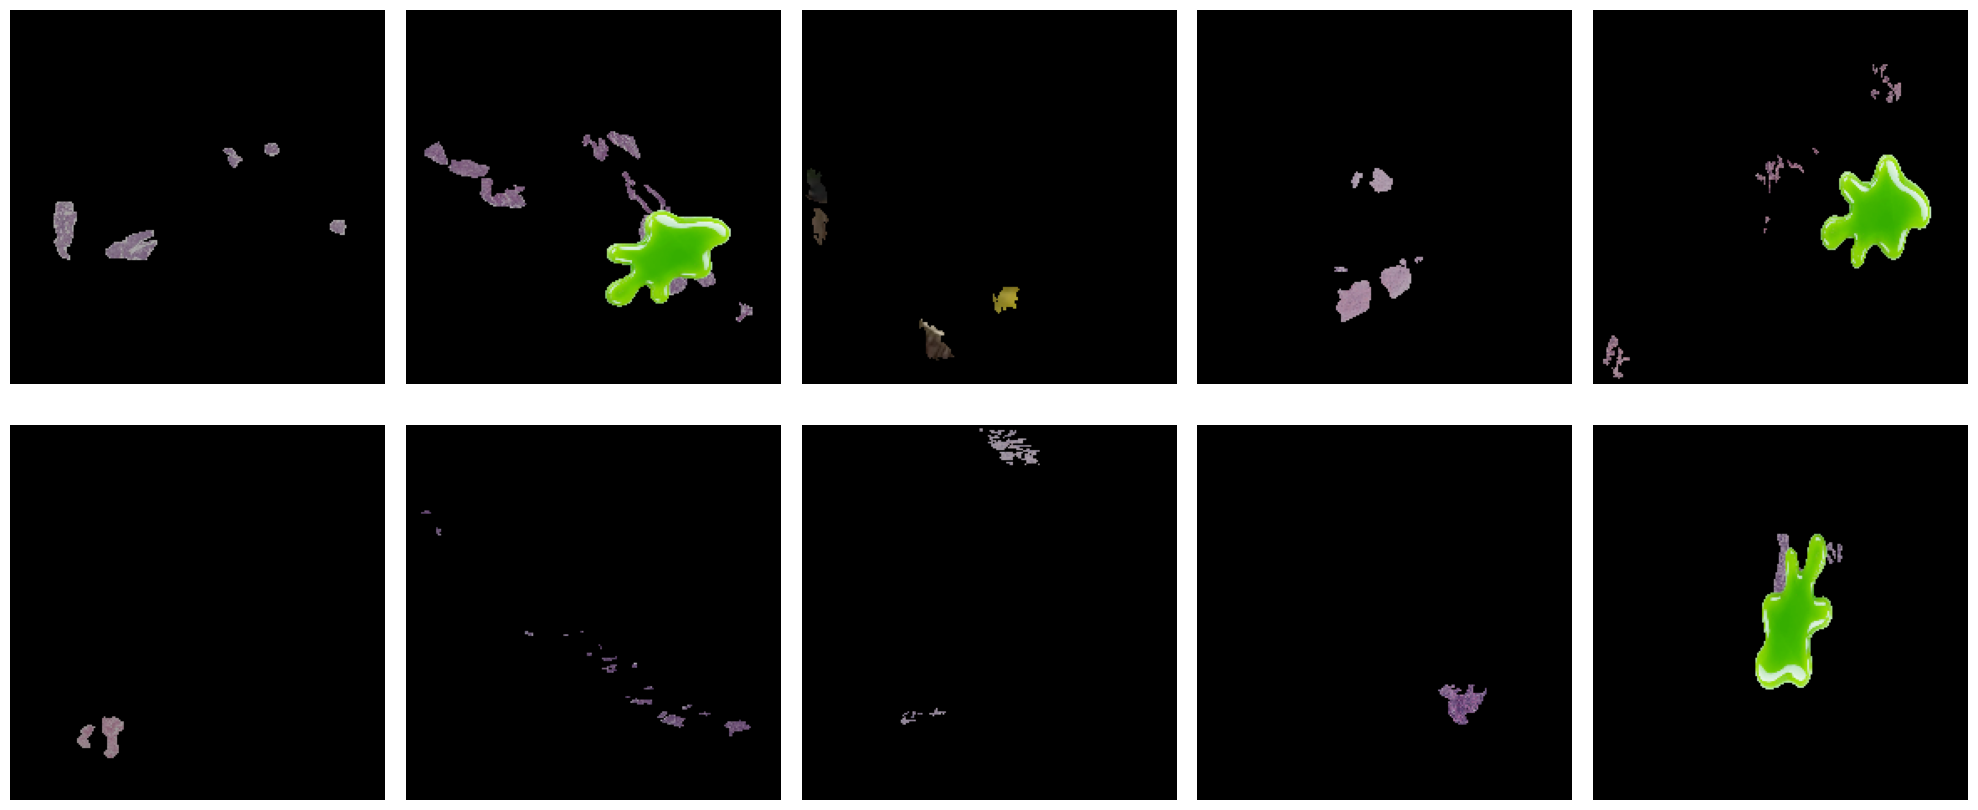

In [101]:
# Number of images to display
num_img = 10
start_img= 100
# Create subplots for displaying items
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(start_img, start_img+num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(train_images[i], 0, 1))  # Display clipped item images
    ax.axis('off')
plt.tight_layout()
plt.show()



### Green Area Removal Filter

This filtering procedure removes bright green regions from images using HSV color space analysis and morphological operations.

**Pipeline:**
1. **HSV Conversion** - Converts image to HSV color space to separate color (Hue) from brightness (Value)
2. **Green Detection** - Creates binary mask for green regions using HSV range: H(10-70), S(10-255), V(10-255)
3. **Morphological Cleaning** - Applies MORPH_OPEN with 5×5 elliptical kernel (2 iterations) to remove noise
4. **Mask Inversion** - Inverts mask to preserve non-green pixels
5. **Application** - Applies inverted mask to remove green areas (replaced with black)

**Key Parameters:**
- Hue Range: 10-70 (green spectrum)
- Kernel: 5×5 ellipse
- Morphological Operations: Opening (erosion → dilation)

In [102]:
def filter_bright_green_areas(image):
    """ Filters out bright green areas from the input image."""

    # Convert from RGB (0-1) to BGR (0-255) for OpenCV
    original_bgr = (image * 255).astype(np.uint8)[..., ::-1]

    # 1. Convert to HSV (Hue, Saturation, Value)
    # This is crucial. We separate Color (H) from Brightness (V).
    hsv = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2HSV)

    # 2. Define the "Bright Green" Range
    # Green hue is roughly 35-85 in OpenCV
    # We also set a minimum Brightness (Value) of 100 to target only "Bright" zones
    lower_green = (60 - 50, 10, 5)  # e.g., (50, 100, 100)
    upper_green = (60 + 100, 255, 255)  # e.g., (70, 255, 255)   

    # Create the initial mask
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # 3. IMPLEMENTING THE KERNEL (Morphology)
    # This is the "Kernel" step you were looking for to save useful pixels.
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

    # Morphological OPEN: Erosions followed by Dilation
    # This removes small "noise" points. If a useful pixel is slightly green 
    # but tiny (like a single pixel reflection), this removes it from the mask.
    clean_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)

    # Morphological DILATE:
    # Expands the green mask slightly to ensure we catch the edges of the green area
    # clean_mask = cv2.morphologyEx(clean_mask, cv2.MORPH_DILATE, kernel, iterations=1)

    # 4. Invert Mask to keep the "Useful" parts
    # currently clean_mask is White where green is. We want the opposite.
    mask_inv = cv2.bitwise_not(clean_mask)

    # 5. Apply the mask
    # Result is black where the green/bright areas were
    result_bgr = cv2.bitwise_and(original_bgr, original_bgr, mask=mask_inv)

    return result_bgr, clean_mask

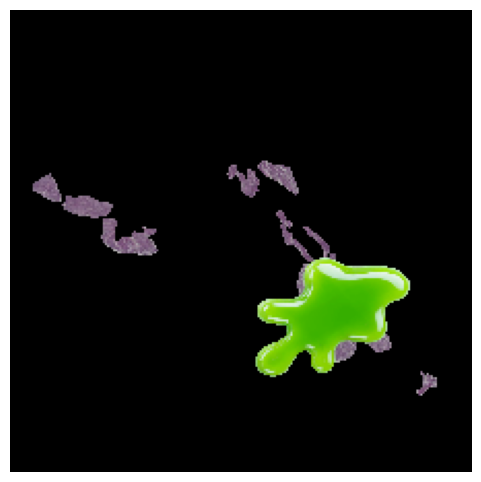

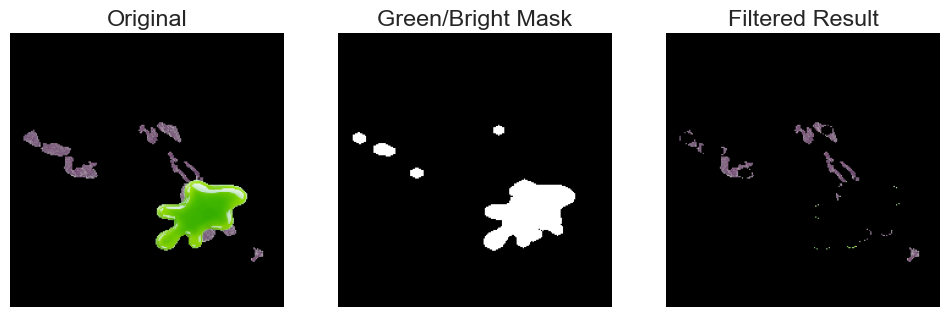

In [103]:
# Display the pixels values of an image with green areas
image_index = 102
image = train_images[image_index]
plt.figure(figsize=(6, 6))
plt.imshow(np.clip(image, 0, 1))
plt.axis('off')
plt.show()

result_bgr, clean_mask = filter_bright_green_areas(image)

# --- Display Results ---
plt.figure(figsize=(12, 6))

# Original
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(np.clip(image, 0, 1))
plt.axis('off')

# The Mask (Visualizing what we are removing)
plt.subplot(1, 3, 2)
plt.title("Green/Bright Mask")
plt.imshow(clean_mask, cmap='gray')
plt.axis('off')

# Result
result_rgb = result_bgr[..., ::-1]
plt.subplot(1, 3, 3)
plt.title("Filtered Result")
plt.imshow(np.clip(result_rgb / 255.0, 0, 1))
plt.axis('off')

plt.show()

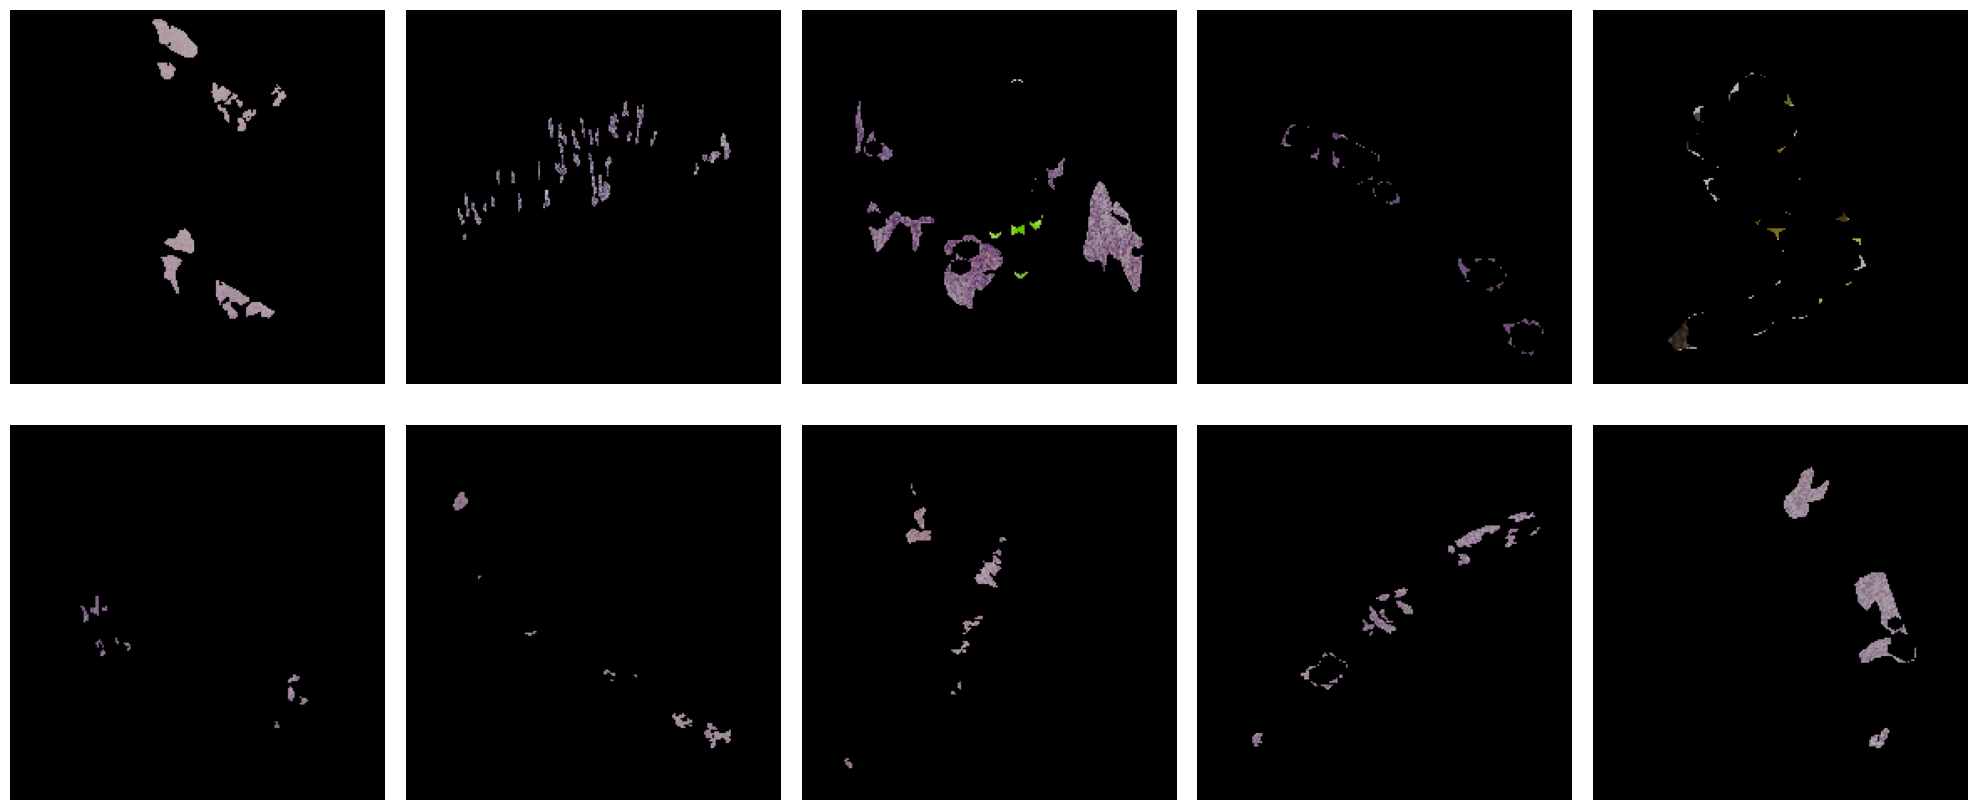

In [107]:
# Convert from BGR to RGB for displaying
result_rgb = result_bgr[..., ::-1]


# Apply the HSV filter for all the images into the training set and normalize them
for image in train_images:
    filtered_bgr, _ = filter_bright_green_areas(image)
    # Convert back to RGB and normalize to [0, 1]
    filtered_rgb = filtered_bgr[..., ::-1] / 255.0
    # Update the image in place
    image[:] = filtered_rgb

# Number of images to display
num_img = 10
start_img= 300
# Create again subplots for displaying the filtered items
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(start_img, start_img+num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(train_images[i], 0, 1))  # Display clipped item images
    ax.axis('off')
plt.tight_layout()
plt.show()


In [108]:
from sklearn.preprocessing import LabelEncoder

# 1. Load the labels CSV
labels_df = pd.read_csv(train_labels_path)
# Create a dictionary mapping filename -> label for fast lookup
labels_map = dict(zip(labels_df.iloc[:, 0], labels_df.iloc[:, 1]))

# 2. Get the filenames corresponding to the images loaded in Cell 7
# IMPORTANT: This must match the order used in 'load_images_from_folder' exactly.
# We re-read the file list to ensure we have the specific names associated with the indices of 'train_images'
filenames = os.listdir(MASKED_IMAGE_PATH)

print("Aligning labels to loaded images...")

X_aligned = []
y_aligned = []

# 3. Iterate through the filenames to sync X (images) and y (labels)
# We assume 'train_images' matches the order of 'filenames' because they rely on the same os.listdir call order
# provided no files were added/deleted between Cell 7 and Cell 9.
if len(filenames) != len(train_images):
    raise ValueError(f"Mismatch! Loaded images ({len(train_images)}) != Files found ({len(filenames)}).")

for i, filename in enumerate(filenames):
    if filename in labels_map:
        # If the file exists in our CSV, keep the image and the label
        X_aligned.append(train_images[i])
        y_aligned.append(labels_map[filename])
    else:
        # If image is in folder but NOT in CSV, we must discard the image
        print(f"Skipping {filename}: Image found but no label in CSV.")

# Convert to numpy arrays
X = np.array(X_aligned)
y = np.array(y_aligned)

print(f"Images aligned: {X.shape}")
print(f"Labels aligned: {y.shape}")

# 4. Encode labels (String -> Integer)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Print class mapping
print("Classes:", label_encoder.classes_)

# 5. Train-Test Split (Stratified)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=SEED, 
    stratify=y_encoded
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=SEED,
    stratify=y_temp
)

print(f"Training data shape: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Labels: {y_val.shape}")
print(f"Test data shape: {X_test.shape}, Labels: {y_test.shape}")

Aligning labels to loaded images...
Images aligned: (1412, 224, 224, 3)
Labels aligned: (1412,)
Classes: ['HER2(+)' 'Luminal A' 'Luminal B' 'Triple negative']
Images aligned: (1412, 224, 224, 3)
Labels aligned: (1412,)
Classes: ['HER2(+)' 'Luminal A' 'Luminal B' 'Triple negative']
Training data shape: (1129, 224, 224, 3), Labels: (1129,)
Validation data shape: (141, 224, 224, 3), Labels: (141,)
Test data shape: (142, 224, 224, 3), Labels: (142,)
Training data shape: (1129, 224, 224, 3), Labels: (1129,)
Validation data shape: (141, 224, 224, 3), Labels: (141,)
Test data shape: (142, 224, 224, 3), Labels: (142,)


In [109]:
# Define the input shape based on the training data
input_shape = (X_train.shape[3], X_train.shape[1], X_train.shape[2])

# Define the number of classes
num_classes = len(np.unique(y_train))

print("Input Shape:", input_shape)
print("Number of Classes:", num_classes)

Input Shape: (3, 224, 224)
Number of Classes: 4


In [110]:
# Convert numpy arrays to PyTorch datasets (without augmentation for now)
train_ds = TensorDataset(
    torch.from_numpy(X_train).permute(0, 3, 1, 2),
    torch.from_numpy(y_train).squeeze().long()
)
val_ds = TensorDataset(
    torch.from_numpy(X_val).permute(0, 3, 1, 2),
    torch.from_numpy(y_val).squeeze().long()
)
test_ds = TensorDataset(
    torch.from_numpy(X_test).permute(0, 3, 1, 2),
    torch.from_numpy(y_test).squeeze().long()
)

In [111]:
# Define the batch size
BATCH_SIZE = 32

In [112]:
def make_loader(ds, batch_size, shuffle, drop_last):
    """
    Create a PyTorch DataLoader with optimized settings.

    Args:
        ds (Dataset): PyTorch Dataset object
        batch_size (int): Number of samples per batch
        shuffle (bool): Whether to shuffle data at each epoch
        drop_last (bool): Whether to drop last incomplete batch

    Returns:
        DataLoader: Configured DataLoader instance
    """
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [113]:
# Create data loaders with different settings for each phase
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [114]:
# Get one batch from the training data loader
for xb, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    break  # Stop after getting one batch

Features batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


## **4. Training Parameters**